# Get started

The following example shows the steps to develop a preventive maintenance policy
by age on circuit breakers:

1. Perform a survival analysis on lifetime data,
2. Compute the optimal age of replacement,
3. Compute the expected total discounting costs and number of expected
   replacements for the next years.

## Survival analysis

The survival analysis is perfomed by computing the Kaplan-Meier estimator and fitting the
parameters of a Weibull and a Gompertz distribution with the maximum likelihood
estimator.

In [1]:
import pandas as pd
from relife2.utils.dataset import load_circuit_breaker

time, event, entry = load_circuit_breaker()
data = pd.DataFrame({
    "time" : time,
    "event" : event,
    "entry" : entry
})
display(data.head(n=15))

,time,event,entry
0,34.0,1.0,33.0
1,28.0,1.0,27.0
2,12.0,1.0,11.0
3,38.0,1.0,37.0
4,18.0,1.0,17.0
5,32.0,1.0,31.0
6,44.0,1.0,43.0
7,49.0,1.0,48.0
8,27.0,1.0,26.0
9,47.0,1.0,46.0


In [2]:
from relife2 import KaplanMeier, Weibull, Gompertz

km = KaplanMeier().fit(time,event,entry)
weibull = Weibull().fit(time,event,entry)
gompertz = Gompertz().fit(time,event,entry)

Here are the estimated parameters after fitting the models (note that ``km`` does note have parameters as it is a non-parametric estimator)

In [3]:
print("Weibull parameters (shape, rate) :", weibull.params)
print("Gompertz parameters (shape, rate) :", gompertz.params)

Weibull parameters (shape, rate) : [3.7267452  0.01232326]
Gompertz parameters (shape, rate) : [0.00390781 0.07579546]


The results of fitting the Weibull and Gompertz distributions are compared by looking at their AIC. Those values are stored in the ``fitting_results`` instance created and saved inside your model instance after the fit.

In [4]:
print("Weibull AIC :", weibull.fitting_results.AIC)
print("Gompertz AIC :", gompertz.fitting_results.AIC)

Weibull AIC : 2493.721978543718
Gompertz AIC : 2485.567310362761


The Gompertz distribution gives the best fit and will be chosen for the next step of the study. The code below plots the survival function obtained by the Kaplan-Meier estimator and the maximum likelihood estimator for the Weibull and Gompertz distributions.

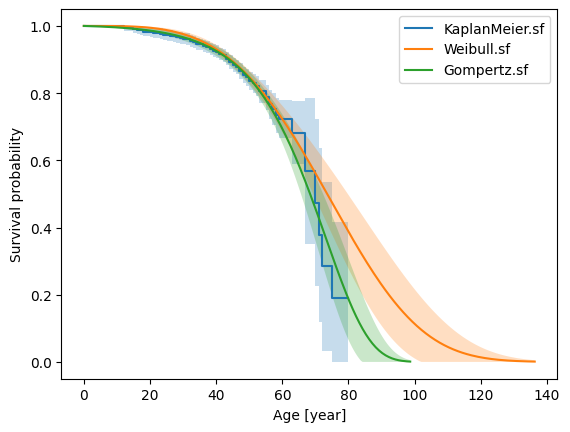

In [5]:
import matplotlib.pyplot as plt

km.plot.sf()
weibull.plot.sf()
gompertz.plot.sf()
plt.xlabel('Age [year]')
plt.ylabel('Survival probability')
plt.show()

## Optimal age replacement

We consider 3 circuit breakers with the following parameters:

- the current ages of the circuit breakers are 15, 20, and 25 years respectively
- the preventive costs of replacement are evaluated 10 k€
- the failure costs (e.g. lost energy) are evaluated 900, 500 and 100 k€ respectively
- the discount rate is 0.04

<div class="alert alert-info">
When you want to pass different parameters for each asset, you generally encode them in a 2D array. The first axis corresponds to each assets and the second axis corresponds to the values.
</div>

Current ages are stored in ``a0``, preventive costs of replacement in ``cp``, failure costs in ``cf``. As there are three assets, we must reshape each array in 2D when necessary. 